In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
from scipy.stats import pearsonr
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from scipy import stats
from scipy.signal import convolve,deconvolve
from sympy import *
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
import warnings
import matplotlib.cbook
import string
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}

#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',
                    'GROWTH_HORMONE_GH':'GH',
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
                     'CORTISOL_U_FREE_24h':'Urinary cortisol',
                     'T3_FREE':'T3-free',
                     'T4_FREE':'T4-free',
                     'ESTRADIOL_E_2':'Estradiol',
                     'TESTOSTERONE_TOTAL':'Testosterone',
                     'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF1'}

residual_hormone_dic={ 'ALDOSTERONE_BLOOD'      :'ALD',
                       'ANDROSTENEDIONE'        :'AND',
                       'ANGIOTENSIN_I_CONVERTING_ENZYME':'ACE',
                       'DHEA_SULPHATE'          :'DHEA',
                       'PARATHYROID_HORMONE_PTH':'PTH',
                       '17_HYDROXY_PROGESTERONE':'17OHPG',
                       'PROGESTERONE'           :'P4'}

pituitary_unit_dict = {'ACTH':'Percentile',
                       'TSH' :'Percentile',
                       'LH'  :'Percentile',
                       'FSH' :'Percentile',
                       'Prolactin':'Percentile',
                       'GH'  :'Percentile'}

effector_unit_dict  = {'Cortisol':'Percentile',
                       'Urinary cortisol':'Percentile',
                       'T3-free':'Percentile',
                       'T4-free':'Percentile',
                       'Estradiol':'Percentile',
                       'Testosterone': 'Percentile',
                       'IGF1' :'Percentile'}

chem_dic            = {'CALCIUM_BLOOD':'Calcium',
                    'CREATININE_BLOOD':'Creatinine',
                    'Cl':'Cl',
                    'GLUCOSE_BLOOD':'Glucose',
                    'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
                    'HGB':'HGB',
                    'MAGNESIUM_BLOOD':'Mg',
                    'POTASSIUM':'K',
                    'SODIUM':'Na',
                    'UREA_BLOOD':'Urea'}
 
month_names = [x[:3] for x in calendar.month_name[1:13]]
letters     = string.ascii_uppercase

In [2]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='quantile'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]

    df = df.loc[df['age_group'] !='[70,80]']
    df = df.loc[df['age_group'] !='[60,70)']
    df = df.loc[df['age_group'] !='[50,60)'] 

    df.loc[df['month'] == 12,['month']] = 0
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    
    # 2st order cosinor - 4 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp*2,np.pi,maxamp*2,np.pi)])
    
    A21          = res_fit[0]
    phi21        = res_fit[1]
    A22          = res_fit[2]
    phi22        = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,hormone,sex,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)
        
    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        

        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))

        if hormone =='TESTOSTERONE_TOTAL':
            if sex =='male':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars))
                
        elif hormone =='ESTRADIOL_E_2':
            if sex =='female':
                winter_peak = pars[:,5] < 6
                all_tests_acrophase  .append(get_acrophase(pars[winter_peak]))
                all_tests_relmaxmin  .append(get_relmaxmin(pars[winter_peak]))
            else:
                all_tests_acrophase  .append(get_acrophase(pars))
                all_tests_relmaxmin  .append(get_relmaxmin(pars)) 
        else:
            all_tests_acrophase  .append(get_acrophase(pars))
            all_tests_relmaxmin  .append(get_relmaxmin(pars))  

        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
        
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    print(all_tests_acrophase)
    print([aic1,aic2,aic_null])
    best_model = np.argmin(np.array([aic1,aic2,aic_null])) 
    if best_model   == 0:
        print('1st order cosinor')
        return cosinor_tables[0]
    elif best_model == 1:
        print('2nd order cosinor')
        return cosinor_tables[1]
    else:
        print('constant')
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
    
    plt.errorbar(np.arange(0,12),ydat,edat,c='k')
    
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='b')

    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    plt.plot(np.linspace(0,12,num = 365),cosine,c='r')
    plt.xticks(ticks=np.arange(0,12))
    plt.grid()
    plt.show()
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='qunaitle'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat,hormone,sex)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='quantile'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):
            print('--------------')
            print(k,sex)
            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}
            print('acrophase = ' ,acrophase)
            print('maxmin/2 = ' ,maxmin)

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

--------------
CORTISOL_BLOOD female


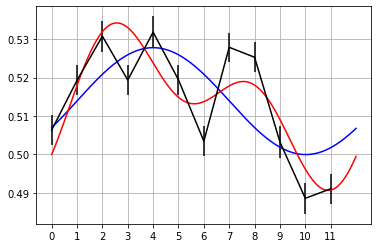

[3.5428298  1.78490453]
[-104.047689200333, -103.938134349462, -101.845710167087]
1st order cosinor
acrophase =  3.5428298016754445
maxmin/2 =  0.023480981061090943
--------------
CORTISOL_BLOOD male


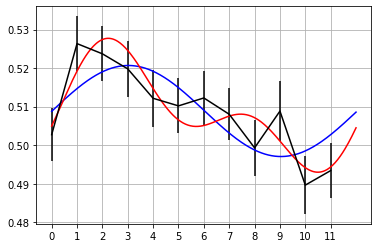

[1.69373158 0.97893222]
[-113.290936260663, -113.191276765022, -108.591168469943]
1st order cosinor
acrophase =  1.6937315811191869
maxmin/2 =  0.021834520433251285
--------------
CORTISOL_BLOOD both


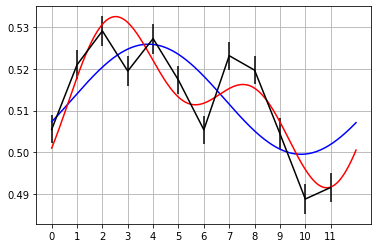

[2.71000582 1.32069915]
[-107.974055232910, -110.384557356459, -104.587855246867]
2nd order cosinor
acrophase =  2.7100058241705507
maxmin/2 =  0.02125571594272529
--------------
CORTISOL_U_FREE_24h female


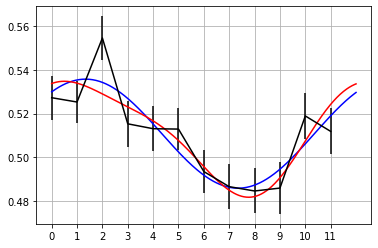

[1.94087507 0.40970684]
[-106.522448920254, -96.8498852637807, -94.1606880710866]
1st order cosinor
acrophase =  1.9408750651114246
maxmin/2 =  0.039361852076269174
--------------
CORTISOL_U_FREE_24h male


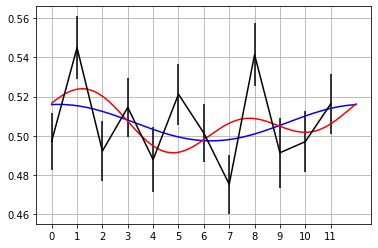

[11.62237826  3.27483279]
[-88.2123978852713, -79.8332194309489, -93.3227251791421]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
CORTISOL_U_FREE_24h both


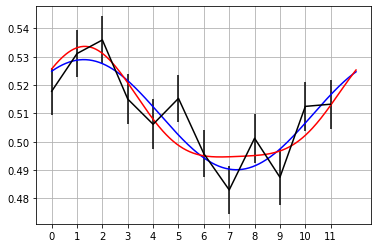

[1.64694972 0.69430177]
[-112.175442063523, -102.257108136889, -100.462898369792]
1st order cosinor
acrophase =  1.646949723334163
maxmin/2 =  0.029921363163084927
--------------
T3_FREE female


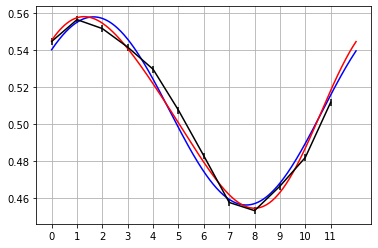

[1.03646858 0.18948498]
[-118.808694579334, -115.391527133977, -79.6571268603822]
1st order cosinor
acrophase =  1.0364685794140331
maxmin/2 =  0.0515636591148515
--------------
T3_FREE male


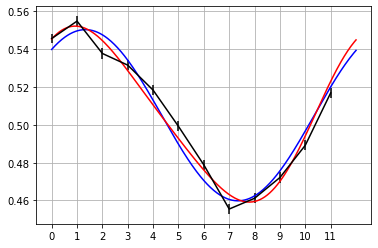

[0.99617824 0.06241705]
[-116.031426404576, -112.582144997534, -82.2490747794834]
1st order cosinor
acrophase =  0.9961782383883282
maxmin/2 =  0.049705088199918646
--------------
T3_FREE both


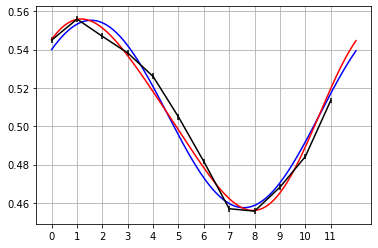

[ 1. -0.]
[-118.018141632265, -114.821531004072, -80.5546227570945]
1st order cosinor
acrophase =  0.9999999999999997
maxmin/2 =  0.05024784510548497
--------------
T4_FREE female


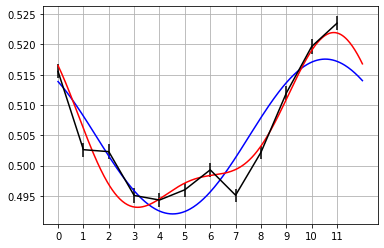

[10.99617824  0.06241705]
[-127.415074347713, -130.557818689687, -110.901858212076]
2nd order cosinor
acrophase =  10.996178238388326
maxmin/2 =  0.014932637571836495
--------------
T4_FREE male


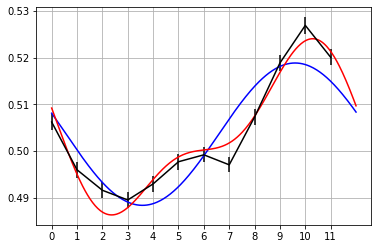

[10.00191037  0.04417392]
[-121.301603127272, -130.098402384615, -106.508070689405]
2nd order cosinor
acrophase =  10.001910370562392
maxmin/2 =  0.01887104606248648
--------------
T4_FREE both


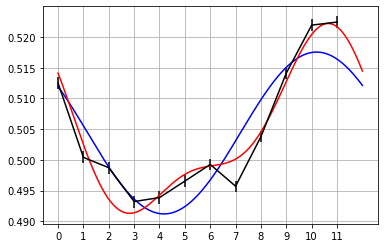

[10.62672651  0.48665972]
[-126.186934570058, -132.191172961695, -110.131369094633]
2nd order cosinor
acrophase =  10.62672651154703
maxmin/2 =  0.014926394262255348
--------------
ESTRADIOL_E_2 female


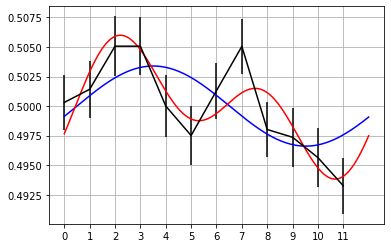

[2.45487942 0.67782645]
[-134.690500209188, -136.442042164938, -134.524470421602]
2nd order cosinor
acrophase =  2.454879420475912
maxmin/2 =  0.007418614709285319
--------------
ESTRADIOL_E_2 male


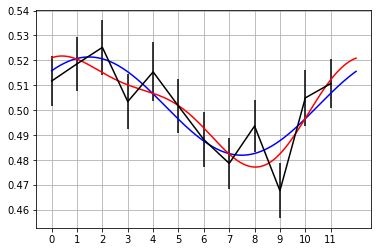

[1.76831992 1.51409455]
[-108.390240841575, -100.146067596514, -98.8969271845947]
1st order cosinor
acrophase =  1.7683199170067179
maxmin/2 =  0.0326102932360516
--------------
ESTRADIOL_E_2 both


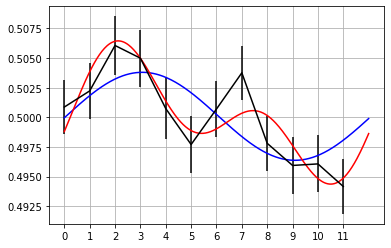

[2.4496359  1.48522949]
[-137.271657709210, -139.877596926573, -134.821452074917]
2nd order cosinor
acrophase =  2.4496358958865327
maxmin/2 =  0.0071727536567819895
--------------
TESTOSTERONE_TOTAL female


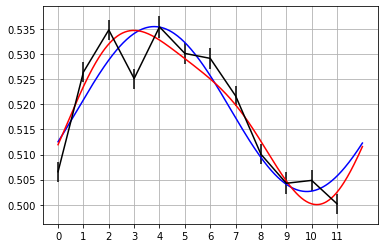

[3.13978758 1.03589309]
[-123.673839916358, -118.298670740478, -105.320784622638]
1st order cosinor
acrophase =  3.1397875844471943
maxmin/2 =  0.018095777987142687
--------------
TESTOSTERONE_TOTAL male


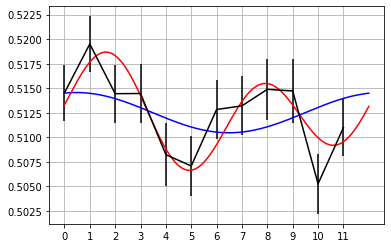

[1.11067262 0.5754835 ]
[-129.274519510951, -132.988624057428, -133.680204282502]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TESTOSTERONE_TOTAL both


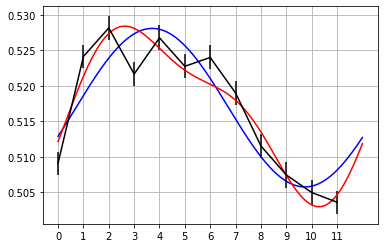

[2.53812941 1.00722713]
[-129.848236484119, -128.551103460541, -114.150413250839]
1st order cosinor
acrophase =  2.538129406977791
maxmin/2 =  0.012727655752397602
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 female


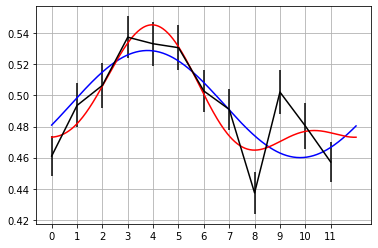

[3.78297389 0.86271303]
[-90.3543381902556, -86.3332613995860, -84.0073061132002]
1st order cosinor
acrophase =  3.7829738941009015
maxmin/2 =  0.055668867912706366
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 male


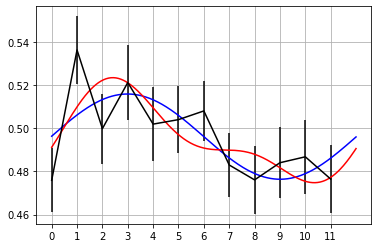

[1.73517895 1.29149666]
[-98.8308811026295, -89.8020345730654, -95.8247177956812]
1st order cosinor
acrophase =  1.7351789479021742
maxmin/2 =  0.040874710241928125
--------------
INSULIN_LIKE_GROWTH_FACTOR_1 both


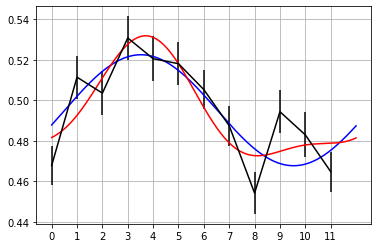

[3.39405803 0.88816313]
[-98.1268201140707, -91.8339843226975, -90.3955179498578]
1st order cosinor
acrophase =  3.394058028957585
maxmin/2 =  0.041288628848367946



--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE female


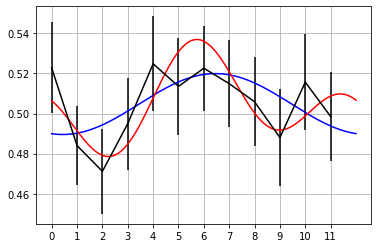

[5.66119388 3.13595479]
[-95.3384406890246, -92.4930682824967, -98.2983554527111]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE male


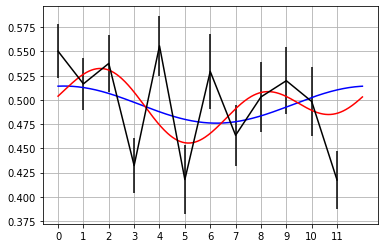

[2.52167878 3.02353751]
[-67.4476438669806, -59.8329262813383, -72.7907899806157]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
ACTH_ADRENOCORTICOTROPIC_HORMONE both


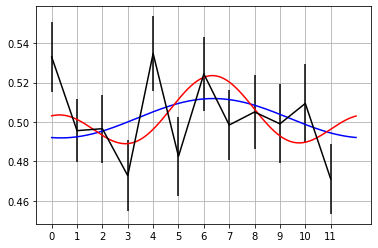

[3.06750291 3.30191042]
[-87.9986242478234, -79.5625785413622, -93.7325745376880]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
TSH_THYROID_STIMULATING_HORMONE female


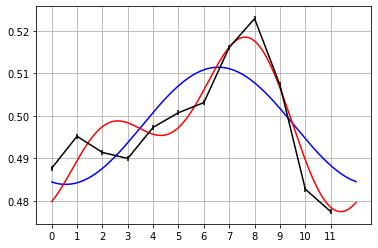

[8.00000000e+00 4.02472757e-08]
[-109.825027678749, -113.464522250913, -104.708859718582]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.022735203054127243
--------------
TSH_THYROID_STIMULATING_HORMONE male


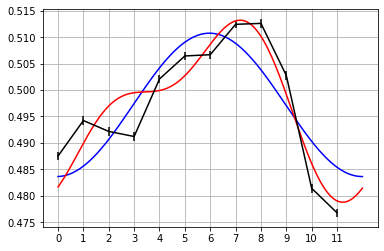

[7.54502524 0.50088086]
[-117.336134930685, -117.493492767719, -107.597479546410]
2nd order cosinor
acrophase =  7.545025239673753
maxmin/2 =  0.018103436209640764
--------------
TSH_THYROID_STIMULATING_HORMONE both


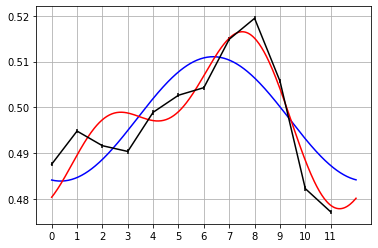

[8.00000000e+00 4.02472757e-08]
[-112.278161561963, -114.944841703054, -105.916924859356]
2nd order cosinor
acrophase =  7.999999999999997
maxmin/2 =  0.02115313043561254
--------------
LH_LUTEINIZING_HORMONE female


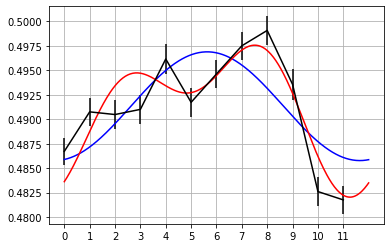

[7.67530289 0.88521062]
[-130.909852105386, -132.343604658084, -126.121390281873]
2nd order cosinor
acrophase =  7.675302888983393
maxmin/2 =  0.009009382059999953
--------------
LH_LUTEINIZING_HORMONE male


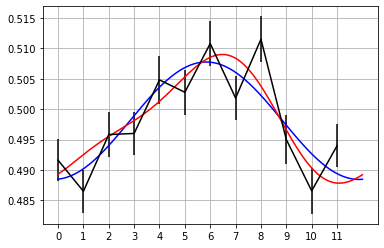

[6.99214056 1.18710826]
[-124.989679881234, -116.763553005864, -115.858074784582]
1st order cosinor
acrophase =  6.992140557701549
maxmin/2 =  0.014716385327460746
--------------
LH_LUTEINIZING_HORMONE both


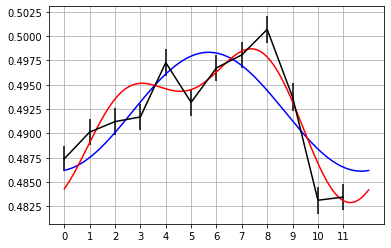

[7.8592793  0.61382644]
[-132.587516110059, -132.835201172335, -125.537486205794]
2nd order cosinor
acrophase =  7.859279303104866
maxmin/2 =  0.009117045672936079
--------------
FSH_FOLLICLE_STIMULATING_HORMONE female


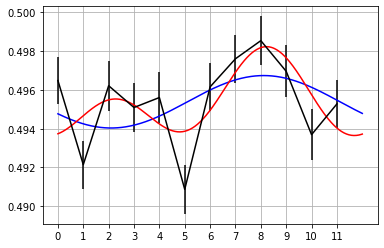

[7.92987801 1.42360179]
[-144.826529226851, -139.804497460501, -147.802453677518]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
FSH_FOLLICLE_STIMULATING_HORMONE male


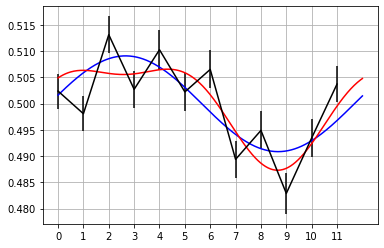

[2.6428307  1.18849536]
[-120.084869282373, -113.596096114358, -114.939658156593]
1st order cosinor
acrophase =  2.6428307019996042
maxmin/2 =  0.01572899077310669
--------------
FSH_FOLLICLE_STIMULATING_HORMONE both


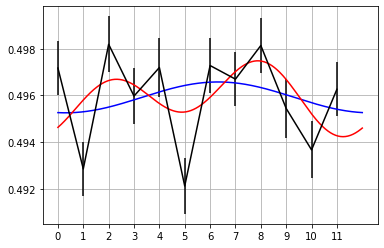

[4.8545335 3.8323145]
[-144.455869701940, -137.507812513689, -149.915197112641]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH female


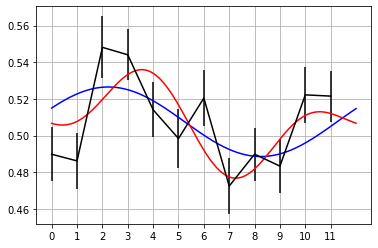

[2.31433413 1.13456062]
[-88.6668337908483, -83.1840396354134, -90.1063754145409]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH male


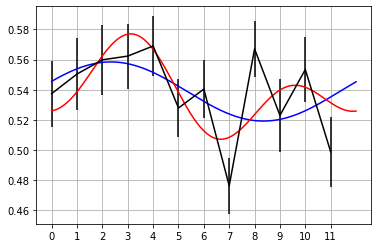

[3.30654568 2.99913508]
[-83.5279893059466, -78.0044535949173, -86.4256120669108]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
GROWTH_HORMONE_GH both


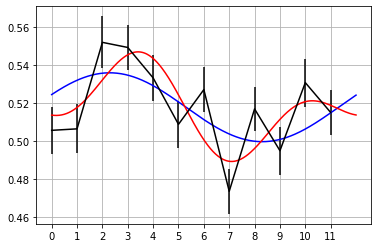

[2.48119056 1.02295065]
[-91.6912627643054, -87.0954452189508, -92.3028001420262]
constant
acrophase =  0.0
maxmin/2 =  0.0
--------------
PROLACTIN female


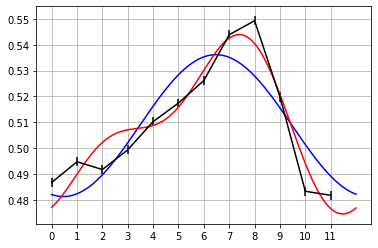

[7.98660608 0.11626053]
[-103.630464798161, -106.723367071936, -91.5496441343453]
2nd order cosinor
acrophase =  7.986606081728747
maxmin/2 =  0.03414490886890503
--------------
PROLACTIN male


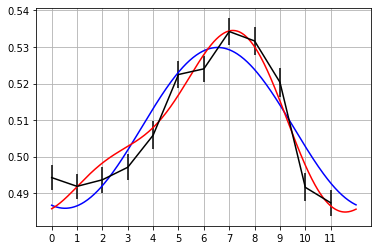

[7.27433676 0.48883514]
[-116.468476245378, -115.866765390756, -98.2340006515781]
1st order cosinor
acrophase =  7.274336755482291
maxmin/2 =  0.024451712762175126
--------------
PROLACTIN both


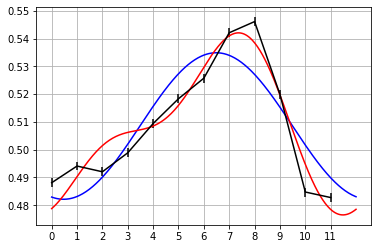

[7.96353142 0.18948498]
[-105.839973091405, -108.832536042114, -92.7325027881292]
2nd order cosinor
acrophase =  7.963531420585966
maxmin/2 =  0.031856662588313316



In [3]:
effector_list  = gen_hormone_list(effector_hormone_dic)
pituitary_list = gen_hormone_list(pituitary_hormone_dic)

In [4]:
pickle.dump([pituitary_list,effector_list],open('seasonality_processed_data1102_20_50.pickle','wb'))

In [5]:
[pituitary_list,effector_list] = pickle.load(open('seasonality_processed_data1102_20_50.pickle','rb'))

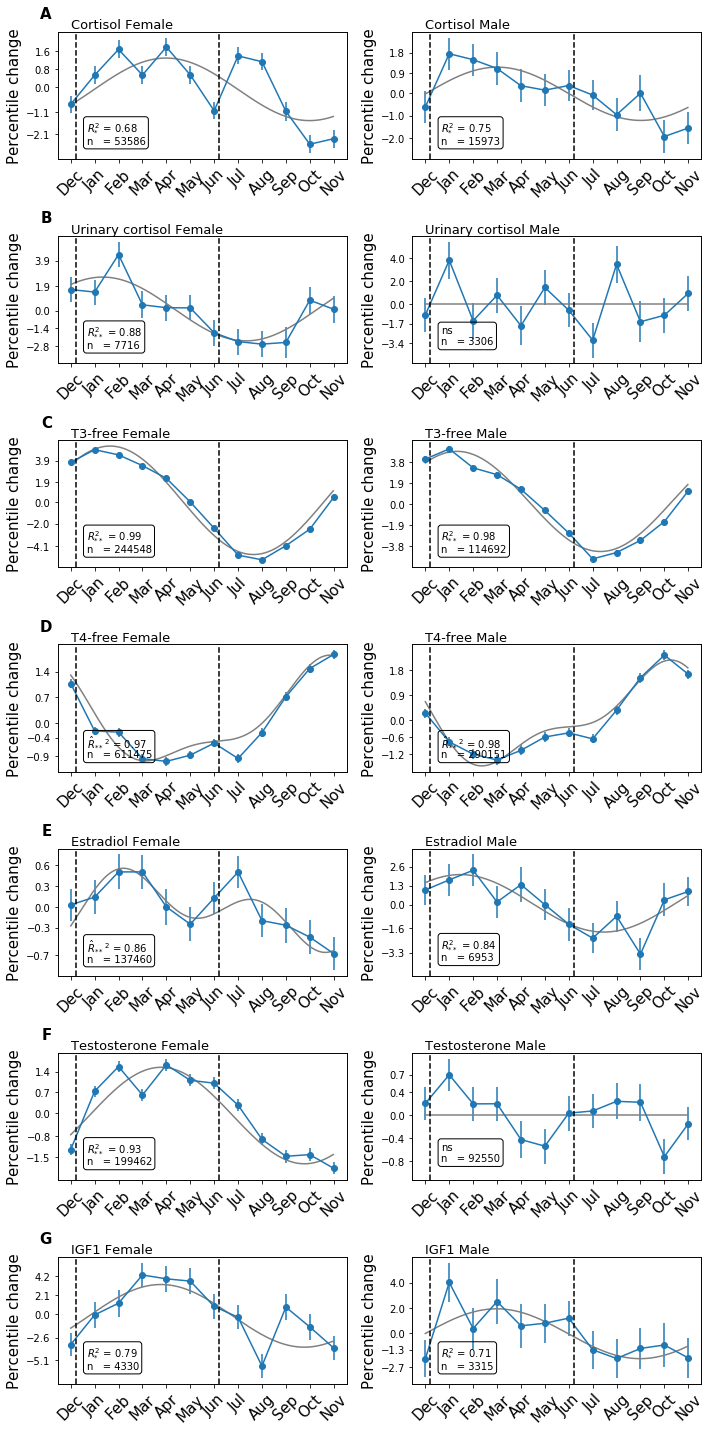

In [6]:
'''
plot effector hormones seasonality
'''
eff_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(effector_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]
                
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        eff_r2df = eff_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))
        
        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        y_percentage   = (yloc-yloc.mean())*100;
        err_precentage = err*100
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        ## x0 = Dec 15, so add 6 days to get Dec 21st
        ## in month resulotion, 6 days are 0.2 month
        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

D:\Anaconda\envs\venv\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


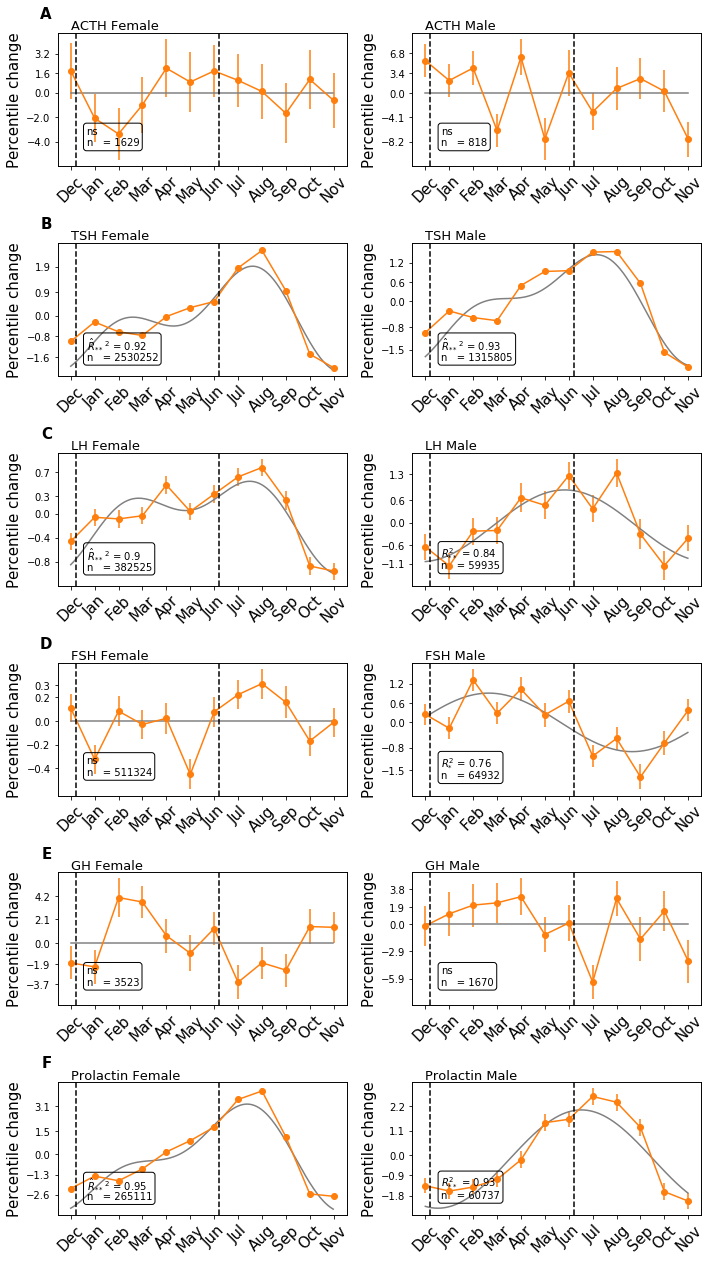

In [7]:
'''
plot pituitary hormones seasonality
'''
pit_r2df = pd.DataFrame(columns = ['sex','hormone','r2'])

plt.figure(figsize=(10,20))
for j,k in tqdm(enumerate(pituitary_hormone_dic.keys())):
    for i,sex in enumerate(['female','male']):        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        # months are stored iin the dataframe in a january-december fmt, 
        # this part will make december as the 0th month
        p        = ((phase)/12)*2*np.pi
        p2       = ((phase2)/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        
        R2,pval  = pearsonr(yloc,cosine2)
        pit_r2df = pit_r2df.append(pd.DataFrame({'sex':sex,'hormone':k,'r2':[R2]}))

        if amp2 >0:
            rstr = '${\^R}^2$'
        elif amp > 0:
            rstr = '$R^2$'
        else:
            rstr = 'ns'
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
            
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        y_percentage = (yloc-yloc.mean())*100;
        fit_percentage = (cosine2[:-30]-cosine2[:-30].mean())*100;
        err_precentage = err*100

        #plot
        ax = plt.subplot(7,2,1+i +j*2)
        ax.errorbar(xloc,y_percentage,err_precentage,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-31],fit_percentage,c='gray')
        ax.set_xticks(np.arange(12))
        ax.set_xticklabels(np.roll(month_names,1), rotation=45,fontsize=15)
        ax.set_ylabel('Percentile change',fontsize=15)
        ax.tick_params(axis="y", labelsize=10)
        ylim = ax.get_ylim();
        yticks = [ylim[0]*2/3,ylim[0]*1/3,0,ylim[1]*1/3,ylim[1]*2/3]
        ax.set_yticks(np.round(yticks,decimals=1))
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr+'\nn   = '+str(ntot)
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) +'\nn   = '+str(ntot)
    
        ax.text(0.1, 0.3, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='none', edgecolor='black'))

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
        if i ==0:
            ax.text(-0.02, 1.2, letters[j], transform=ax.transAxes,fontsize = 15, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

# FIG 1 complete

In [8]:
def HPA_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('A'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('ACTH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Cortisol',[-1.12+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.725, 0.2, 0.2], anchor='SW', zorder=-1)
    
    newax.imshow(plt.imread('../figures/ppt/glands/adrenal.png'))
    
    newax.text(0.2, 1.08, 'Stress adaptation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    
    newax.text(0.2, 0.2, 'Adrenal Cortex', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    

    newax.text(0.16, 1.09, 'A', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')

    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def HPT_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('TSH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('T4'   ,[-1.015+xoff ,-0.8+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('T3'   ,[-1.015+xoff ,-1.1+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.7 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.8 +Yoff],
                xy    =[-0.97  +xoff ,-1 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
       
    newax = fig.add_axes([-0.2, 0.528, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/thyroid.png'))
    
    newax.text(0.2, 1.08, 'Thermoregulation \n   & metabolism', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, 'Thyroid', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'B', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)
    
def HPG_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.1 
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('G'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('LH'   ,[-0.9+xoff ,-0.15+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('FSH'  ,[-0.9+xoff ,-0.35+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('Test',[-0.9+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('E2'  ,[-1.2+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.82  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-1.12  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.357, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/gonads.png'))
    
    newax.text(0.2, 1.08, 'Reproduction', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.2, '  Gonads', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'C', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    

def HPL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.6     
    ax.annotate('H'    ,[-1  +xoff   ,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1  +xoff   ,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('L'    ,[-1  +xoff   ,-0.45+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[0])
    ax.annotate('GH'  ,[-0.9+xoff ,-0.25+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('IGF-1',[-1.05+xoff ,-0.85+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[0])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , 0.3 +Yoff],
                xy    =[-0.97  +xoff ,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.1 +Yoff],
                xy    =[-0.97  +xoff ,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff , -0.5 +Yoff],
                xy    =[-0.97  +xoff ,-0.75 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",lw =0.5,color=def_color[0],shrinkB=5,connectionstyle="arc3,rad=0"))
    
    newax = fig.add_axes([-0.2, 0.133, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/liver.png'))
    
    newax.text(0.2, 1.08, 'Growth', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.56, '    Liver', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'D', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)

def PRL_graph_on_axe(ax,fig):
    xoff = 0.3 ;  Yoff = 0.45 
    ax.annotate('H'    ,[-1   +xoff,0.35 +Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color='k')
    ax.annotate('P'    ,[-1   +xoff,-0.05+Yoff],fontsize=15,fontweight='bold',xycoords='axes fraction',color=def_color[1])
    ax.annotate('PRL'  ,[-1.05+xoff,-0.45+Yoff],fontsize=14,fontweight='bold',xycoords='axes fraction',color=def_color[1])

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, 0.3 +Yoff],
                xy    =[-0.97  +xoff,0.05 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color='k',shrinkB=5,connectionstyle="arc3,rad=0"))

    ax.annotate('',fontsize=12,
                xytext=[-0.97  +xoff, -0.1 +Yoff],
                xy    =[-0.97  +xoff,-0.35 +Yoff],
                xycoords='axes fraction',textcoords='axes fraction',
                color='k',fontweight='normal',
                arrowprops=dict(arrowstyle="simple",color=def_color[1],shrinkB=5,connectionstyle="arc3,rad=0"))

    newax = fig.add_axes([-0.2, 0.035, 0.2, 0.2], anchor='SW', zorder=-1)
    newax.imshow(plt.imread('../figures/ppt/glands/breasts.png'))
    
    newax.text(0.2, 1.08, 'Lactation', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                    verticalalignment='top', bbox=dict(boxstyle='square', fc=def_color[0], ec='none',alpha=0.3))
    newax.text(0.35, 0.45, '    Breasts', transform=newax.transAxes, fontsize=15,fontweight='normal',c='k',
                        verticalalignment='top')    
    newax.text(0.16, 1.09, 'E', transform=newax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
    newax.axis('off')
    line = plt.Line2D([-2,5],[1.15,1.15], transform=ax.transAxes, color="dimgray")
    fig.add_artist(line)    
        
def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=15,empty=False,fontsize=15):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,mec='k')
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]),fontsize=fontsize)
    

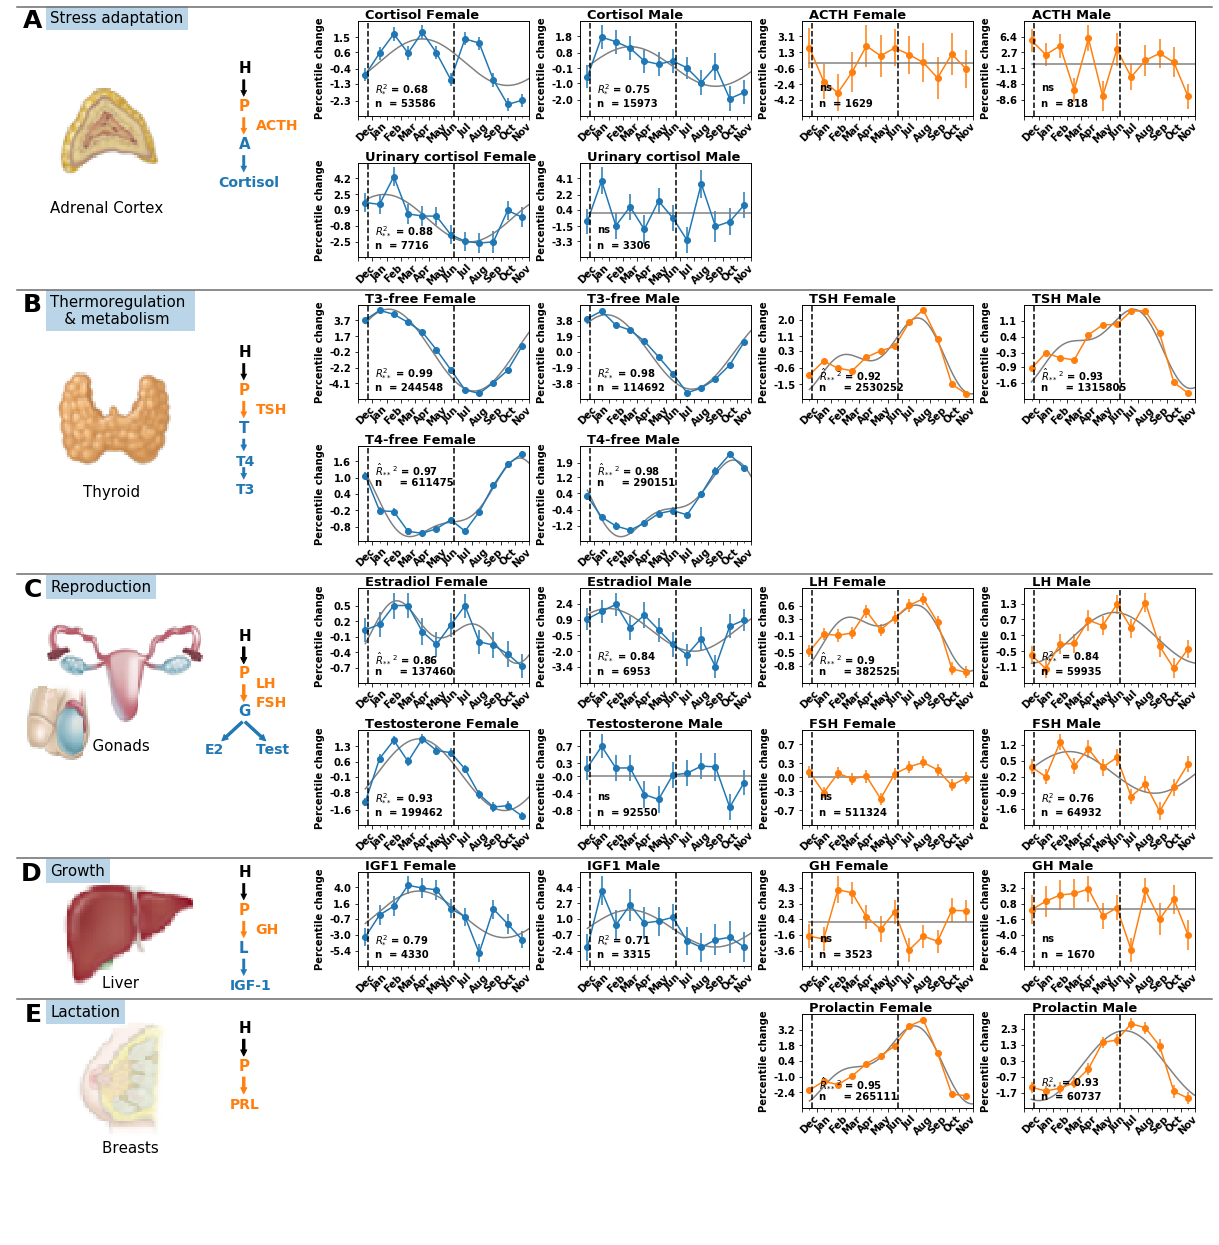

In [9]:
'''
FIG 1 -  Code to plot cosinor fit subplots
'''
plt.rcParams["font.weight"] = "bold"
fig = plt.figure(figsize=(15,20))
gs  = fig.add_gridspec(8, 4)
ax  = fig.add_subplot(gs[0,0]); HPA_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[2,0]); HPT_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[4,0]); HPG_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[6,0]); HPL_graph_on_axe(ax,fig); 
ax  = fig.add_subplot(gs[7,0]); PRL_graph_on_axe(ax,fig);  ax.axis('off')
month_names0  = np.roll(month_names,1)

for j,k in enumerate(effector_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = effector_list[effector_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = effector_list[effector_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = effector_list[effector_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = effector_list[effector_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)
            
        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
           
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100
        fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[j,i])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[0],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel('Percentile change',fontsize=10,fontweight='bold')
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        axn = ax.twinx()
        axn.set_yticks([])
        
        axn.annotate(effector_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 
            
        if k == 'T4_FREE':
            ax.text(0.1, 0.85, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.675, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        else:
            ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
            ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

        axn.axvline(x=0.2,ls='--',c='k')
        axn.axvline(x=6.2,ls='--',c='k')
             
PIT_ORDER = [0,2,4,5,6,7]
for j,k in enumerate(pituitary_hormone_dic.keys()):
    for i,sex in enumerate(['female','male']):
        
        xloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['xloc']
        yloc    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['yloc']
        err     = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['err']
        ntot    = pituitary_list[pituitary_hormone_dic[k]][sex]['Clalit']['ntot']
        phase   = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][0]
        amp     = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor']['pars'][0][1]
        phase2  = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][0]
        amp2    = pituitary_list[pituitary_hormone_dic[k]][sex]['Cosinor2']['pars'][0][1]

        p        = (phase/12)*2*np.pi
        p2       = (phase2/12)*2*np.pi
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
        R2,pval  = pearsonr(yloc,cosine2)
        
        if amp2 >0:
            rstr = '${\^R}^2$'
            nstr = 'n     = '+str(ntot)
        elif amp > 0:
            rstr = '$R^2$'
            nstr = 'n  = '+str(ntot)
        else:
            rstr = 'ns'
            nstr = 'n  = '+str(ntot)

        if pval<0.001:
            rstr = rstr.replace('R','R_{**}')
        elif pval<0.05:
            rstr = rstr.replace('R','R_{*}')
        
        cosine0  = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
        cosine2  = cosine0 + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
        
        data_percentile = (yloc-yloc.mean())*100;  fit_percentile  = (cosine2-cosine2.mean())*100
        #plot
        ax = fig.add_subplot(gs[PIT_ORDER[j],i+2])
        ax.errorbar(xloc,data_percentile,err*100,c=def_color[1],fmt='-o')
        ax.plot(np.arange(0,12,12/365)[:-1],fit_percentile,c='gray')
        
        ax.set_ylabel('Percentile change',fontsize=10,fontweight='bold')        
        ax.tick_params(axis="y", labelsize=10)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xticks(np.arange(0,13,1)-0.5)
        ax.set_xticklabels([])
        ax.set_xticks(np.arange(0,12,1),minor=True)
        ax.set_xticklabels(month_names0[::1], rotation=45,fontsize=10,fontweight='bold',minor =True)
        ax.set_xlim([-0.5,11.5])
        
        if ax.get_ylim()[1]<0.7:
            ax.set_ylim([-1,1])
        
        ylim = ax.get_ylim();
        ax.set_yticks(np.round(np.linspace(ylim[0],ylim[1],7)[1:-1],decimals=1))
        
        axn = ax.twinx(); axn.set_yticks([]); 
        axn.axvline(x=0.2,ls='--',c='k'); axn.axvline(x=6.2,ls='--',c='k')
        
        axn.annotate(pituitary_hormone_dic[k]+' '+ sex.capitalize(),(0,0),xytext =(0,1.025),fontsize=13)
        if rstr == 'ns':
            textstr = rstr
        else:
            textstr = rstr+' = '+str(np.round(R2,decimals=2)) 

        ax.text(0.1, 0.35, textstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')
        ax.text(0.1, 0.175, nstr, transform=ax.transAxes,fontweight='bold', fontsize=10,verticalalignment='top')

plt.subplots_adjust(hspace=0.5,wspace =0.3)
plt.savefig('../figures/Seasonality11022020/SI_Figure_20_50_1102.pdf',bbox_inches='tight',dpi=600)
plt.show()